# Data exploration & feature engineering
In this part, I explore the relationship between variables and labels; do log operation to some variables and label; To n_jobs, transform the value -1 to 16 based on its real meaning; check if the variables are skew; do dummies to categorical variable penalty and do zscore to regularize variables.
I also tried to check if the cross items have the influence to the final result. But they are not. So I cut those part of  code.

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color=sns.color_palette()
sns.set_style('darkgrid')

from scipy.stats import norm, skew
from scipy import stats

In [2]:
trainset=pd.read_csv('train.csv')
testFeatures=pd.read_csv('test.csv')

In [3]:
testFeatures.drop('id',axis=1,inplace=True)
trainset.drop('id',axis=1,inplace=True)

In [4]:
print(trainset.shape)
print(testFeatures.shape)

(400, 14)
(100, 13)


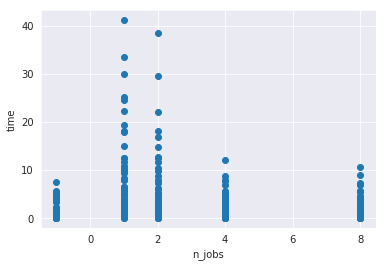

In [6]:
#to see if there is obvious outliers or obvious relationship between variables and target.
fig,ax=plt.subplots()
ax.scatter(x=trainset['n_jobs'],y=trainset['time'])
plt.ylabel('time')
plt.xlabel('n_jobs')
plt.show()

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


3.202330447435379 5.259199425913566


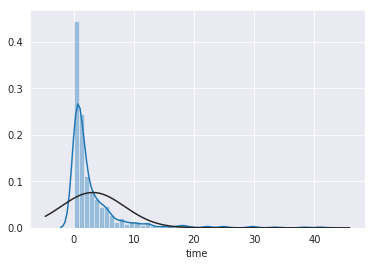

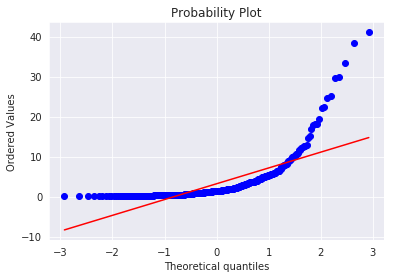

In [7]:
#to see label's distribution
sns.distplot(trainset['time'],fit=norm)

(mu,sigma)=norm.fit(trainset['time'])
print(mu,sigma)#mu均值 sigma标准差

fig=plt.figure()
res=stats.probplot(trainset['time'],plot=plt)
plt.show()

1.0518700689352982 0.7780349549999597


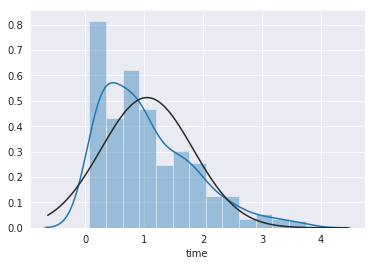

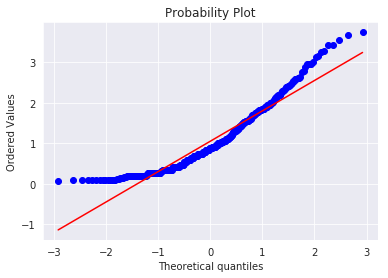

In [8]:
#do log to label to make it more suitable to linear model
trainset['time']=np.log1p(trainset['time'])
sns.distplot(trainset['time'],fit=norm)

(mu,sigma)=norm.fit(trainset['time'])
print(mu,sigma)#mu均值 sigma标准差

fig=plt.figure()
res=stats.probplot(trainset['time'],plot=plt)
plt.show()

In [9]:
ntrain=trainset.shape[0]
ntest=testFeatures.shape[0]
y_train=trainset.time.values
allData=pd.concat((trainset,testFeatures)).reset_index(drop=True)
allData.drop(['time'],axis=1,inplace=True)

(500, 13)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [10]:
#because the number of alpha is too small so do log to it to expand the different between the values of alpha
allData['alpha']=np.log(allData['alpha'])
allData['n_jobs']=allData['n_jobs'].replace(-1,16)
allData['n_jobs']=np.log(allData['n_jobs'])

In [11]:
#to check if there are skew parameters
numeric_feats=allData.dtypes[allData.dtypes!='object'].index
skewed_feats=allData[numeric_feats].apply(lambda x:skew(x.dropna())).sort_values(ascending=False)
skewness=pd.DataFrame({'skew':skewed_feats})
skewness.head(14)

,skew
n_samples,3.952103e-01
n_features,2.019974e-01
n_informative,1.170456e-01
n_clusters_per_class,1.074707e-01
max_iter,4.537942e-02
n_classes,3.433968e-02
flip_y,2.674283e-02
random_state,1.509845e-02
n_jobs,1.400962e-02
alpha,7.207975e-16


In [12]:
#do dummies to the categorical value penalty
allData=pd.get_dummies(allData)

In [13]:
#do zscore to regularize values
a=allData.iloc[0,:].index.values

from scipy.stats import zscore  
for feature in a:
    allData[feature]=zscore(allData[feature])

In [14]:
print(allData.shape)

(500, 16)


In [15]:
train=allData[:ntrain]
test=allData[ntrain:]

# Model Construction
I tried many ways to decrease mse, and finally, I found stacking in kaggle and it really decrease the mse markedly.

I chose ENet, gradient boost, XGBoot, LightGBM as the base models, and lasso as the meta model.
To GBoost, XGBoost and LightGBM, I used gridresearch to turn parameters to get better performance.

In [17]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [18]:
#define the function to get mse value of k fold
n_folds =5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [30]:
lasso=make_pipeline(RobustScaler(),Lasso(alpha=0.0005,random_state=1))
score=rmsle_cv(lasso)
print(score.mean(),score.std())

0.3066961738373136 0.04252145255887378


In [21]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.7, random_state=3))
#ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.001, l1_ratio=.7, random_state=3))
score=rmsle_cv(ENet)
print(score.mean(),score.std())

0.3090695595769145 0.04503493014218369


In [22]:
KRR = KernelRidge(alpha=0.6, kernel='poly', degree=2, coef0=2.5)
score=rmsle_cv(KRR)
print(score.mean(),score.std())

0.18531971473654402 0.015966460694310035


In [23]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=3, max_features='sqrt',
                                   min_samples_leaf=12, min_samples_split=30, 
                                   loss='huber', random_state =5)
score=rmsle_cv(GBoost)
print(score.mean(),score.std())

0.23735893211640552 0.026728039103474495


In [24]:
model_xgb = xgb.XGBRegressor(n_estimators=1200,
                             max_depth=3,min_child_weight=5,
                             gamma=0.1,
                             colsample_bytree=0.762,subsample=0.689,
                             reg_alpha=0.05,reg_lambda=1)
score=rmsle_cv(model_xgb)
print(score.mean(),score.std())

0.24434114478079136 0.02611686917293549


In [25]:
model_lgb = lgb.LGBMRegressor(learing_rate=0.1,n_estimators=1250,
                              max_depth=4,num_leaves=5,
                              min_child_samples=19,
                              feature_fraction=0.5,baging_fraction=0.6)
score=rmsle_cv(model_lgb)
print(score.mean(),score.std())

0.23633854506093374 0.01819781144829692


In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
#do gridsearch to turn parameters
cv_params={}
other_params={'learing_rate':0.1,'n_estimators':1250,'max_depth':4,'num_leaves':5,
             'min_child_samples':19,
             'feature_fraction':0.5,'baging_fraction':0.6}
model = lgb.LGBMRegressor(**other_params)
print(model)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
optimized_GBM.fit(train,y_train)
evalute_result = optimized_GBM.cv_results_
print('parameter：{0}'.format(optimized_GBM.best_params_))
print('score:{0}'.format(optimized_GBM.best_score_))

LGBMRegressor(baging_fraction=0.6, boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, feature_fraction=0.5, importance_type='split',
       learing_rate=0.1, learning_rate=0.1, max_depth=4,
       min_child_samples=19, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1250, n_jobs=-1, num_leaves=5, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


parameter：{}
score:-0.056187068223026805


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


In [28]:
#define the stacking class
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [32]:
stacked_averaged_models = StackingAveragedModels(base_models = (lasso,GBoost, KRR,model_xgb,model_lgb),
                                                 meta_model = ENet)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1867 (0.0185)


In [33]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [34]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.09279611472317018


In [33]:
result=stacked_pred

Becuase the final result must bigger than 0, so to predicted result, let all values smaller then 0 be 0

In [34]:
for i in range(len(result)):
    if result[i]<0:
        result[i]=0
print(result)

[1.30951261e+00 8.74802412e+00 3.30340802e-01 3.22668046e-01
 1.08673746e+00 8.41610277e+00 2.03183285e+00 6.60420762e-01
 1.15885343e+01 4.62279066e-01 4.21172445e+00 1.54417254e+01
 6.31374019e-01 3.37338065e+01 2.75395399e-01 8.05889063e-01
 7.81314249e-01 7.08252048e+00 2.69076728e+00 1.09574042e+00
 2.61518243e-01 0.00000000e+00 4.80702129e-01 7.64458180e-01
 1.63253934e+00 2.30181259e-01 1.92185041e+00 2.60006333e+00
 2.72135650e+00 2.37384754e+00 1.29887969e+01 2.50019426e+00
 4.68858687e-01 5.44234416e+00 7.03560422e+00 9.77534568e-01
 3.56224328e+00 2.21427870e+00 6.98472407e-01 2.31572135e+00
 3.87881868e+00 1.18360014e+01 9.50259417e-01 2.65435306e+00
 8.98502260e-01 3.58106183e+00 3.36691667e+00 6.88236470e-01
 6.85418461e+00 7.36950119e-01 3.30141742e-02 2.39942283e+01
 2.56424477e-01 5.86554904e+00 7.68655329e+00 1.44219271e-01
 8.31168782e-01 8.89556769e-01 8.47022980e-01 1.20788362e+00
 1.17069738e+00 5.94898331e+00 2.58906678e-02 4.24443098e+00
 3.36906606e+00 7.043457

In [35]:
result=pd.DataFrame(result)
result.columns=['time']
result['id']=result.index
result=result[['id','time']]
result.to_csv('result.csv',index=0)